# Wendling Neural Mass Model - MVP Notebook

## Overview

This notebook demonstrates the **Wendling-Chauvel neural mass model** using BrainPy. The Wendling model is a biophysically-based computational model that simulates the dynamics of a cortical column, capturing the interaction between pyramidal cells and three types of interneurons:

- **Pyramidal cells**: Main excitatory neurons
- **Excitatory interneurons**: Provide excitatory feedback
- **Slow inhibitory interneurons**: GABA_A receptors at soma (slow)
- **Fast inhibitory interneurons**: GABA_A receptors at dendrites (fast)

The model uses **10 coupled ODEs** (5 membrane potentials + 5 derivatives) to simulate local field potential (LFP) dynamics and can reproduce various oscillatory patterns observed in EEG/MEG recordings.

### Key Features:
- Realistic neural dynamics with physiologically plausible parameters
- Can generate oscillations in alpha, beta, and gamma frequency bands
- Models the balance between excitation and inhibition
- Useful for studying epileptiform activity and auditory steady-state responses (ASSR)

### References:
- Wendling et al. (2002). *European Journal of Neuroscience*, 15(9):1499-1508
- Köksal Ersöz et al. (2020). *PLoS Computational Biology*, 16(11):e1008430

---

## Environment Setup

This notebook uses the `modeling` conda environment:

```bash
conda activate modeling
```

**Required packages:**
- brainpy >= 2.5.0
- numpy
- matplotlib
- scipy
- jupyter

---

# Section 1: Setup & Imports

In [ ]:
# Standard BrainPy imports
import brainpy as bp
import brainpy.math as bm
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import tqdm as notebook_tqdm

# Set computation platform to GPU (falls back to CPU if GPU unavailable)
try:
    bm.set_platform('gpu')
except Exception as exc:
    print(f"GPU not available, falling back to CPU: {exc}")
    bm.set_platform('cpu')

# Import Wendling model and stimulus generators
import sys
sys.path.append('../..')  # Add parent directory to path
from core_wendling.wendling_bp import WendlingSingleNode, get_default_params
from core_wendling.stim import BaselineStimulus, SineStimulus

print("BrainPy version:", bp.__version__)
print("Platform:", bm.get_platform())
print("✓ Imports successful!")

In [ ]:
# === Wendling parameter sets (6 types) ===
from core_wendling.wendling_param_sets import WENDLING_TYPE_PARAMS, list_type_params

selected_type = 'Type1'  # Type1..Type6
print('Available types:', ', '.join(list_type_params()))
print('Selected type:', selected_type)
type_params = WENDLING_TYPE_PARAMS[selected_type]['params']
print('Selected params:', type_params)


Available types: Type1, Type2, Type3, Type4, Type5, Type6
Selected type: Type1
Selected params: {'A': 5.0, 'B': 50.0, 'G': 15.0, 'p_mean': 90.0, 'p_sigma': 30.0}


---

# Section 2: Configuration Panel

This section contains all the parameters you can adjust to explore different model behaviors.

## 2.1 Model Parameters

The Wendling model has three key parameter groups:

### **Gains (A, B, G)** - Control response amplitude
- `A`: Excitatory gain (mV) - controls excitatory postsynaptic potential amplitude
- `B`: Slow inhibitory gain (mV) - controls slow GABA_A IPSP amplitude
- `G`: Fast inhibitory gain (mV) - controls fast GABA_A IPSP amplitude

### **Time constants (a, b, g)** - Control response speed
- `a`: Excitatory time constant (1/s) - decay rate of excitatory responses
- `b`: Slow inhibitory time constant (1/s) - decay rate of slow inhibition
- `g`: Fast inhibitory time constant (1/s) - decay rate of fast inhibition

### **Sigmoid parameters** - Control firing rate transfer
- `e0`: Half-max firing rate (Hz)
- `v0`: Firing threshold (mV)
- `r`: Sigmoid slope (1/mV)

In [ ]:
# === Model Parameters ===
config = {
    # Gains (mV) - control response amplitude
    'A': 5.0,      # Excitatory gain
    'B': 22.0,     # Slow inhibitory gain
    'G': 18.0,     # Fast inhibitory gain

    # Time constants (1/s) - control response speed
    'a': 100.0,    # Excitatory time constant
    'b': 50.0,     # Slow inhibitory time constant
    'g': 500.0,    # Fast inhibitory time constant

    # Sigmoid parameters - control firing rate transfer
    'e0': 2.5,     # Half-max firing rate (Hz)
    'v0': 6.0,     # Firing threshold (mV)
    'r': 0.56,     # Sigmoid slope (1/mV)

    # Input parameters
    'p_mean': 90.0,   # Mean baseline input (Hz)
    'p_sigma': 2.0,   # Input noise std (Hz)

    # Simulation settings
    'dt_ms': 0.1,     # Time step (ms)
    'seed': 42,       # Random seed for reproducibility
}

# Override with selected Wendling type parameters
config.update(type_params)

print("Configuration loaded:")
print(f"  Selected type: {selected_type}")
print(f"  Gains: A={config['A']} mV, B={config['B']} mV, G={config['G']} mV")
print(f"  Time constants: a={config['a']} 1/s, b={config['b']} 1/s, g={config['g']} 1/s")
print(f"  Baseline input: {config['p_mean']} ? {config['p_sigma']} Hz")
print(f"  Time step: {config['dt_ms']} ms")


Configuration loaded:
  Selected type: Type1
  Gains: A=5.0 mV, B=50.0 mV, G=15.0 mV
  Time constants: a=100.0 1/s, b=50.0 1/s, g=500.0 1/s
  Baseline input: 90.0 ? 30.0 Hz
  Time step: 0.1 ms


## 2.2 Quick Presets (Optional)

Uncomment one of these presets to quickly explore different parameter regimes:

```python
# === Quick Presets ===

# Preset 1: Default (Normal activity)
# Use config as defined above

# Preset 2: High excitation (increased oscillations)
# config['A'] = 10.0  # Increased excitatory gain

# Preset 3: Reduced inhibition (can lead to epileptiform activity)
# config['B'] = 10.0  # Reduced slow inhibitory gain
# config['G'] = 8.0   # Reduced fast inhibitory gain

# Preset 4: Slower dynamics
# config['a'] = 50.0
# config['b'] = 25.0
# config['g'] = 250.0
```

## 2.3 Stimulus Configuration

Choose one of three stimulus options:
1. **Baseline only**: No external stimulus (baseline noise only)
2. **Constant input**: Step input during specified time window
3. **Sinusoidal**: Periodic stimulus for ASSR experiments

In [ ]:
# === Stimulus Options ===

# Option 1: No external stimulus (baseline noise only) - DEFAULT
# stim_config = {
#     'kind': 'baseline',
#     'amp': 0.0,
#     'onset_ms': 0.0,
#     'offset_ms': 10000.0
# }

# Option 2: Constant external input
# Uncomment to use:
# stim_config = {
#     'kind': 'baseline',
#     'amp': 10.0,        # Constant input amplitude (Hz)
#     'onset_ms': 1000.0,  # Start time
#     'offset_ms': 9000.0  # End time
# }

# Option 3: Sinusoidal stimulus (ASSR paradigm)
# Uncomment to use:
stim_config = {
    'kind': 'sine',
    'f_hz': 40.0,       # Stimulus frequency (Hz)
    'amp': 5.0,         # Amplitude (Hz)
    'onset_ms': 1000.0,
    'offset_ms': 9000.0
}

print("Stimulus configuration:")
print(f"  Type: {stim_config['kind']}")
print(f"  Amplitude: {stim_config['amp']} Hz")
if stim_config['kind'] == 'sine':
    print(f"  Frequency: {stim_config.get('f_hz', 'N/A')} Hz")
print(f"  Window: [{stim_config['onset_ms']}, {stim_config['offset_ms']}] ms")

Stimulus configuration:
  Type: sine
  Amplitude: 5.0 Hz
  Frequency: 40.0 Hz
  Window: [1000.0, 9000.0] ms


## 2.4 Simulation Duration

In [ ]:
# === Simulation Duration ===
duration_ms = 10000.0  # 10 seconds

print(f"Simulation duration: {duration_ms} ms ({duration_ms/1000.0} seconds)")
n_steps = int(duration_ms / config['dt_ms'])
print(f"Number of time steps: {n_steps}")

Simulation duration: 10000.0 ms (10.0 seconds)
Number of time steps: 100000


---

# Section 3: Model Initialization

Create an instance of the Wendling model with the configured parameters.

In [ ]:
# Initialize the Wendling single-node model
model = WendlingSingleNode(config)

print("\n" + "="*60)
print("Wendling Model Initialized")
print("="*60)
print("\nModel Architecture: 10-ODE system")
print("  - 5 membrane potential variables (y0, y1, y2, y3, y4)")
print("  - 5 derivative variables (y5, y6, y7, y8, y9)")
print("\nKey Parameters:")
print(f"  Excitatory gain (A): {model.A} mV")
print(f"  Slow inhibitory gain (B): {model.B} mV")
print(f"  Fast inhibitory gain (G): {model.G} mV")
print(f"  Time constants: a={model.a}, b={model.b}, g={model.g} (1/s)")
print(f"  Baseline input: {model.p_mean} ± {model.p_sigma} Hz")
print("\nState Variables:")
print("  y0: Pyramidal → Excitatory (mV)")
print("  y1: Excitatory → Pyramidal (EPSP, mV)")
print("  y2: Slow Inhibitory → Pyramidal (IPSP, mV)")
print("  y3: Fast Inhibitory → Pyramidal (IPSP, mV)")
print("  y4: Pyramidal → Fast Inhibitory (mV)")
print("\nOutput Observable:")
print("  LFP = y1 - y2 - y3 (EPSP - slow_IPSP - fast_IPSP)")
print("="*60)


Wendling Model Initialized

Model Architecture: 10-ODE system
  - 5 membrane potential variables (y0, y1, y2, y3, y4)
  - 5 derivative variables (y5, y6, y7, y8, y9)

Key Parameters:
  Excitatory gain (A): 5.0 mV
  Slow inhibitory gain (B): 50.0 mV
  Fast inhibitory gain (G): 15.0 mV
  Time constants: a=100.0, b=50.0, g=500.0 (1/s)
  Baseline input: 90.0 ± 30.0 Hz

State Variables:
  y0: Pyramidal → Excitatory (mV)
  y1: Excitatory → Pyramidal (EPSP, mV)
  y2: Slow Inhibitory → Pyramidal (IPSP, mV)
  y3: Fast Inhibitory → Pyramidal (IPSP, mV)
  y4: Pyramidal → Fast Inhibitory (mV)

Output Observable:
  LFP = y1 - y2 - y3 (EPSP - slow_IPSP - fast_IPSP)


---

# Section 4: Simulation Execution

Set up the BrainPy DSRunner and run the simulation.

## 4.1 Setup Runner with Monitors

We'll monitor all state variables and the LFP signal.

In [ ]:
# Setup DSRunner with monitors for all key variables
runner = bp.DSRunner(
    model,
    monitors={
        'y0': model.y0,  # Pyr -> Exc
        'y1': model.y1,  # Exc -> Pyr (EPSP)
        'y2': model.y2,  # SlowInh -> Pyr
        'y3': model.y3,  # FastInh -> Pyr
        'y4': model.y4,  # Pyr -> FastInh
        'lfp': model._lfp  # LFP proxy
    },
    dt=config['dt_ms']
)

print("DSRunner configured with monitors:")
print("  - y0, y1, y2, y3, y4 (membrane potentials)")
print("  - lfp (local field potential proxy)")
print(f"  - dt = {config['dt_ms']} ms")

DSRunner configured with monitors:
  - y0, y1, y2, y3, y4 (membrane potentials)
  - lfp (local field potential proxy)
  - dt = 0.1 ms


## 4.2 Generate Stimulus Array

In [ ]:
# Generate stimulus array based on configuration
if stim_config['kind'] == 'baseline':
    stim_obj = BaselineStimulus(
        amp=stim_config['amp'],
        onset_ms=stim_config['onset_ms'],
        offset_ms=stim_config['offset_ms'],
        dt_ms=config['dt_ms']
    )
else:  # sine
    stim_obj = SineStimulus(
        f_hz=stim_config['f_hz'],
        amp=stim_config['amp'],
        onset_ms=stim_config['onset_ms'],
        offset_ms=stim_config['offset_ms'],
        dt_ms=config['dt_ms']
    )

# Generate full stimulus array
stim_array = stim_obj.get_array(duration_ms)

print(f"Stimulus array generated:")
print(f"  Shape: {stim_array.shape}")
print(f"  Range: [{stim_array.min():.3f}, {stim_array.max():.3f}] Hz")
print(f"  Mean: {stim_array.mean():.3f} Hz")
print(f"  Non-zero elements: {np.count_nonzero(stim_array)}/{len(stim_array)}")

Stimulus array generated:
  Shape: (100000,)
  Range: [-5.000, 5.000] Hz
  Mean: -0.000 Hz
  Non-zero elements: 80000/100000


## 4.3 Run Simulation

In [ ]:
# Run the simulation
print(f"\nRunning simulation for {duration_ms} ms...\n")
runner.run(inputs=stim_array)
print("\nSimulation complete!")



Running simulation for 10000.0 ms...



Running for 100,000 iterations: 100%|██████████| 100000/100000 [00:00<00:00, 144103.65it/s]


Simulation complete!


---

# Section 5: Data Extraction & Processing

Extract time series data from the monitors.

In [ ]:
# Extract monitored data
ts = runner.mon['ts']  # Time array (ms)
lfp = runner.mon['lfp']  # LFP signal
y0 = runner.mon['y0']
y1 = runner.mon['y1']
y2 = runner.mon['y2']
y3 = runner.mon['y3']
y4 = runner.mon['y4']

# Verify LFP computation
lfp_computed = y1 - y2 - y3
lfp_diff = np.abs(lfp - lfp_computed).max()

print("Data extracted from monitors:")
print(f"  Time series length: {len(ts)} samples")
print(f"  Duration: {ts[-1]:.2f} ms")
print(f"  Sampling rate: {1000.0 / config['dt_ms']:.1f} Hz")
print("\nState variable ranges:")
print(f"  y0 (Pyr→Exc): [{y0.min():.2f}, {y0.max():.2f}] mV")
print(f"  y1 (Exc→Pyr): [{y1.min():.2f}, {y1.max():.2f}] mV")
print(f"  y2 (SlowInh→Pyr): [{y2.min():.2f}, {y2.max():.2f}] mV")
print(f"  y3 (FastInh→Pyr): [{y3.min():.2f}, {y3.max():.2f}] mV")
print(f"  y4 (Pyr→FastInh): [{y4.min():.2f}, {y4.max():.2f}] mV")
print(f"\nLFP signal:")
print(f"  Range: [{lfp.min():.2f}, {lfp.max():.2f}] mV")
print(f"  Mean: {lfp.mean():.2f} mV")
print(f"  Std: {lfp.std():.2f} mV")
print(f"  LFP computation verified: max difference = {lfp_diff:.2e} mV")

Data extracted from monitors:
  Time series length: 100000 samples
  Duration: 9999.90 ms
  Sampling rate: 10000.0 Hz

State variable ranges:
  y0 (Pyr→Exc): [0.00, 0.02] mV
  y1 (Exc→Pyr): [0.00, 7.14] mV
  y2 (SlowInh→Pyr): [0.00, 7.03] mV
  y3 (FastInh→Pyr): [0.00, 0.51] mV
  y4 (Pyr→FastInh): [0.00, 0.21] mV

LFP signal:
  Range: [-0.80, 1.55] mV
  Mean: -0.56 mV
  Std: 0.17 mV
  LFP computation verified: max difference = 0.00e+00 mV


---

# Section 6: Visualization

Visualize the simulation results with multiple views.

## 6.1 Time Series - All State Variables

Display all membrane potential variables and the LFP signal over time.

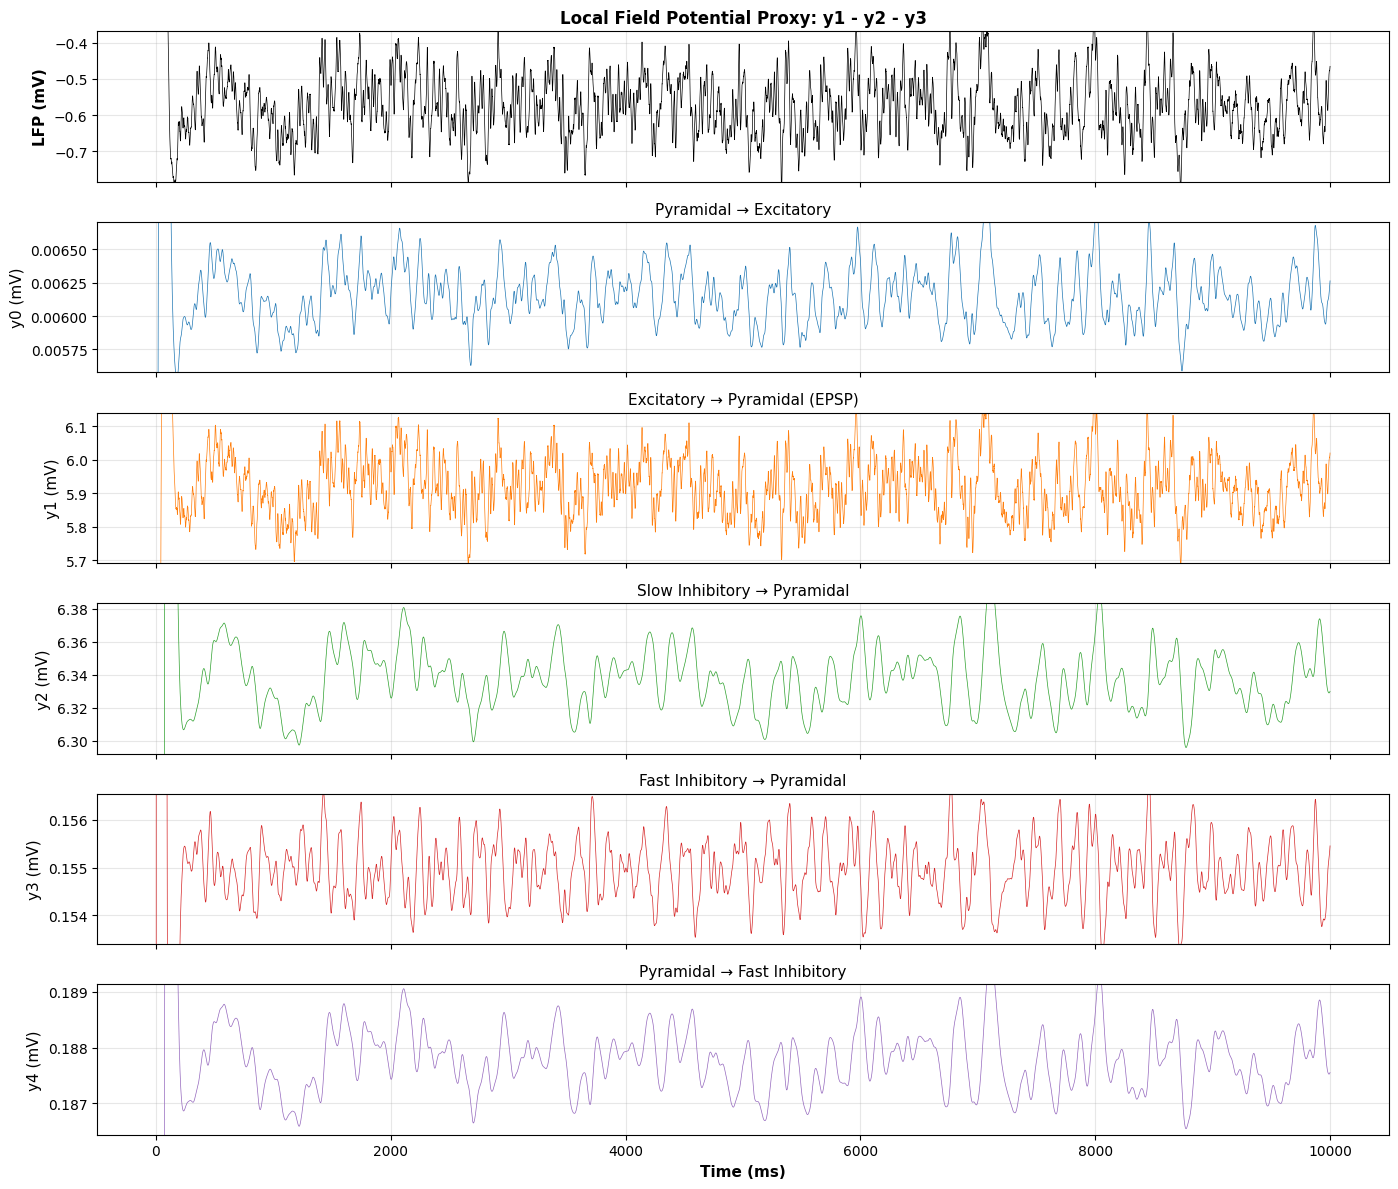

In [ ]:
fig, axes = plt.subplots(6, 1, figsize=(14, 12), sharex=True)

# --- Auto y-axis scaling (centered, per-axis) ---
auto_ylim = True
scale_start_ms = 2000.0  # compute scale using data after this time
center_mode = 'median'   # 'median' or 'mean'
ylim_pct = 98            # percentile of |signal-center|
target_fill = 0.9        # 0.8-0.9 recommended
pad_frac = (1.0 / target_fill) - 1.0

def set_centered_ylim(ax, x, y, start_ms=0.0, center='median', pct=98, pad=0.1):
    import numpy as np
    yy = np.asarray(y)
    if start_ms and x is not None:
        mask = np.asarray(x) >= start_ms
        yy = yy[mask]
    yy = yy[np.isfinite(yy)]
    if yy.size == 0:
        return
    if center == 'mean':
        c = float(np.mean(yy))
    else:
        c = float(np.median(yy))
    amp = np.percentile(np.abs(yy - c), pct)
    if amp == 0:
        amp = 1
    amp = amp * (1 + pad)
    ax.set_ylim(c - amp, c + amp)


# Panel 1: LFP (the main observable)
axes[0].plot(ts, lfp, 'k', linewidth=0.5)
if auto_ylim:
    set_centered_ylim(axes[0], ts, lfp, start_ms=scale_start_ms, center=center_mode, pct=ylim_pct, pad=pad_frac)
axes[0].set_ylabel('LFP (mV)', fontsize=11, fontweight='bold')
axes[0].set_title('Local Field Potential Proxy: y1 - y2 - y3', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].axhline(0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Panel 2-6: Individual state variables
state_vars = [
    (y0, 'y0 (mV)', 'Pyramidal → Excitatory', 'C0'),
    (y1, 'y1 (mV)', 'Excitatory → Pyramidal (EPSP)', 'C1'),
    (y2, 'y2 (mV)', 'Slow Inhibitory → Pyramidal', 'C2'),
    (y3, 'y3 (mV)', 'Fast Inhibitory → Pyramidal', 'C3'),
    (y4, 'y4 (mV)', 'Pyramidal → Fast Inhibitory', 'C4')
]

for i, (data, ylabel, title, color) in enumerate(state_vars, 1):
    axes[i].plot(ts, data, linewidth=0.5, color=color)
    if auto_ylim:
        set_centered_ylim(axes[i], ts, data, start_ms=scale_start_ms, center=center_mode, pct=ylim_pct, pad=pad_frac)
    axes[i].set_ylabel(ylabel, fontsize=11)
    axes[i].set_title(title, fontsize=11)
    axes[i].grid(alpha=0.3)
    axes[i].axhline(0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

axes[-1].set_xlabel('Time (ms)', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

## 6.2 Power Spectral Density

Analyze the frequency content of the LFP signal using Welch's method.

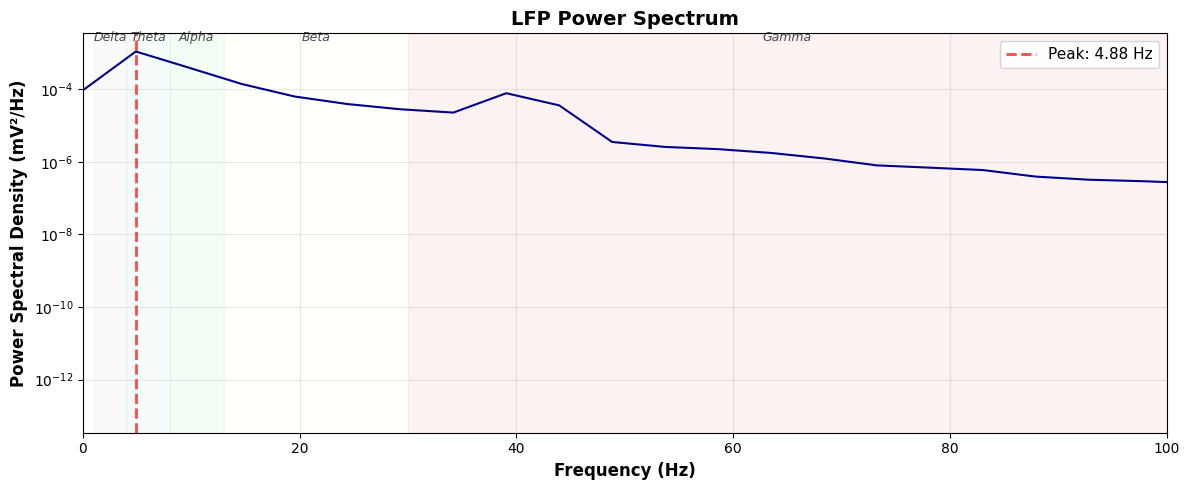


Spectral Analysis Results:
  Dominant frequency: 4.88 Hz
  Peak power: 1.11e-03 mV²/Hz
  Band classification: Theta (4-8 Hz)


In [ ]:
# Compute PSD using Welch's method
fs = 1000.0 / config['dt_ms']  # Sampling frequency (Hz)
freqs, psd = signal.welch(lfp[:, 0], fs=fs, nperseg=2048)

# Find dominant frequency
freq_mask = freqs < 100
peak_idx = np.argmax(psd[freq_mask])
peak_freq = freqs[freq_mask][peak_idx]
peak_power = psd[freq_mask][peak_idx]

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
ax.semilogy(freqs, psd, linewidth=1.5, color='darkblue')
ax.axvline(peak_freq, color='red', linestyle='--', linewidth=2, alpha=0.7, 
           label=f'Peak: {peak_freq:.2f} Hz')
ax.set_xlabel('Frequency (Hz)', fontsize=12, fontweight='bold')
ax.set_ylabel('Power Spectral Density (mV²/Hz)', fontsize=12, fontweight='bold')
ax.set_title('LFP Power Spectrum', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
ax.set_xlim([0, 100])  # Focus on 0-100 Hz
ax.legend(fontsize=11)

# Add frequency band annotations
bands = [
    (1, 4, 'Delta', 'lightgray'),
    (4, 8, 'Theta', 'lightblue'),
    (8, 13, 'Alpha', 'lightgreen'),
    (13, 30, 'Beta', 'lightyellow'),
    (30, 100, 'Gamma', 'lightcoral')
]
for f_low, f_high, band_name, color in bands:
    ax.axvspan(f_low, f_high, alpha=0.1, color=color)
    ax.text((f_low + f_high) / 2, ax.get_ylim()[1] * 0.5, band_name, 
            ha='center', va='bottom', fontsize=9, style='italic', alpha=0.7)

plt.tight_layout()
plt.show()

print(f"\nSpectral Analysis Results:")
print(f"  Dominant frequency: {peak_freq:.2f} Hz")
print(f"  Peak power: {peak_power:.2e} mV²/Hz")

# Classify dominant frequency band
if peak_freq < 4:
    band = "Delta (1-4 Hz)"
elif peak_freq < 8:
    band = "Theta (4-8 Hz)"
elif peak_freq < 13:
    band = "Alpha (8-13 Hz)"
elif peak_freq < 30:
    band = "Beta (13-30 Hz)"
else:
    band = "Gamma (30-100 Hz)"
print(f"  Band classification: {band}")

## 6.3 Phase Portraits (State Space Dynamics)

Visualize the dynamical behavior in state space to understand attractor structure.

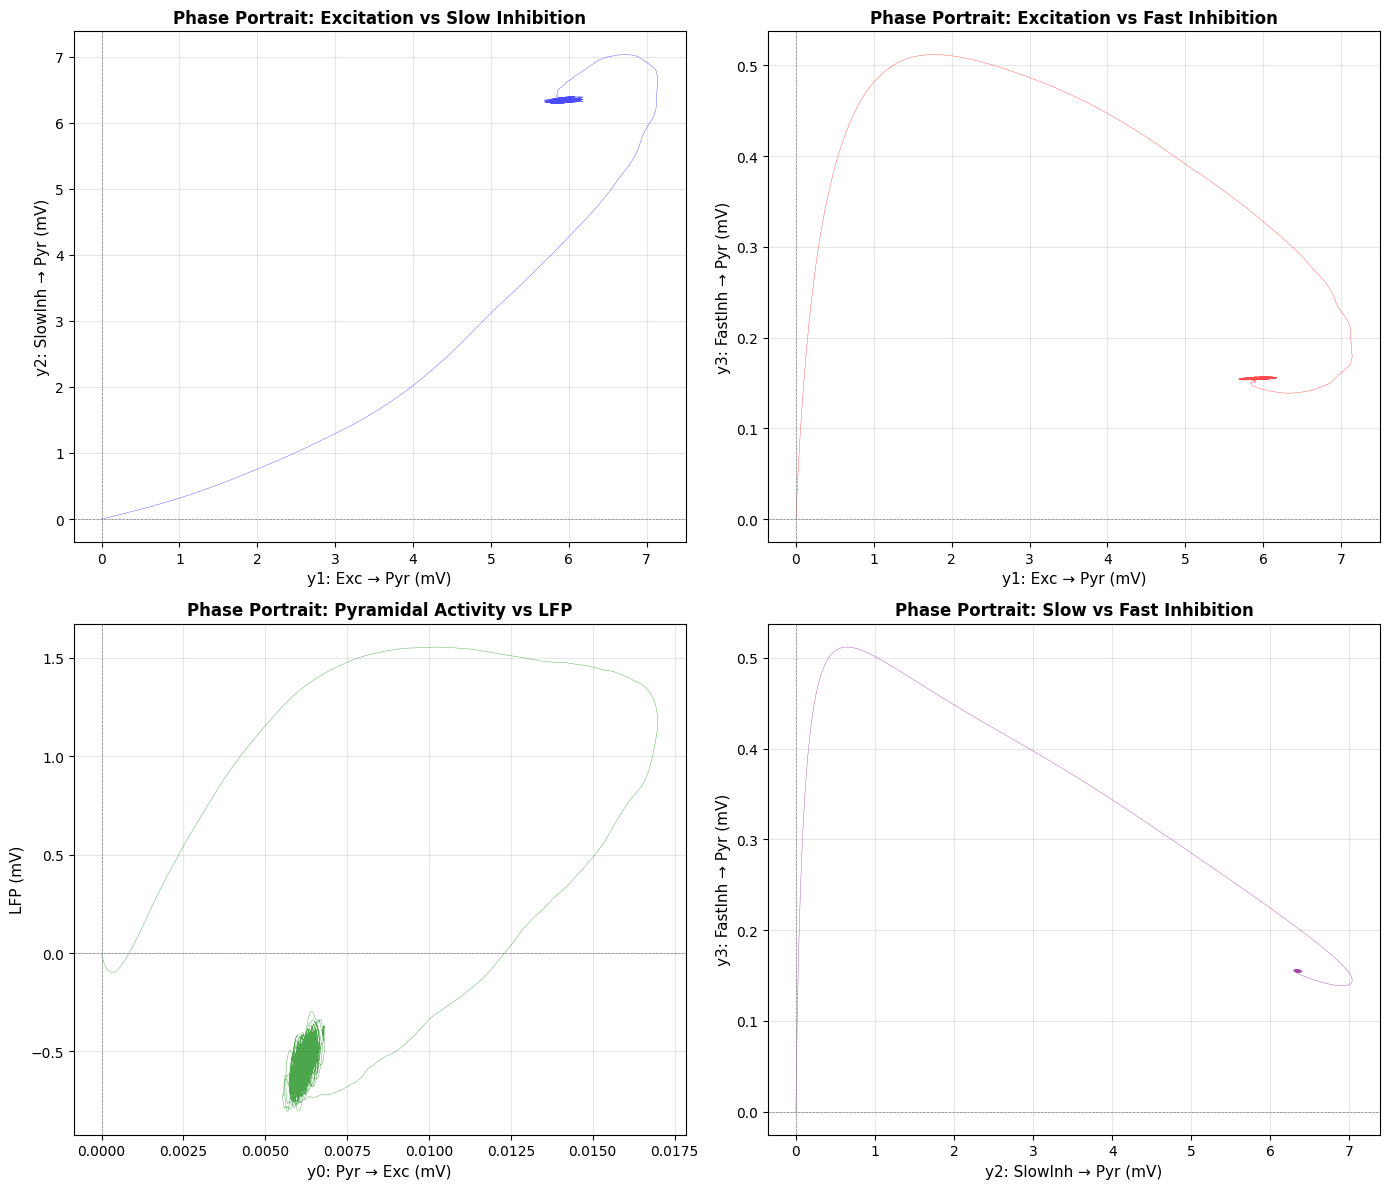

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: y1 vs y2 (Excitation vs Slow Inhibition)
axes[0, 0].plot(y1[:, 0], y2[:, 0], linewidth=0.3, alpha=0.7, color='blue')
axes[0, 0].set_xlabel('y1: Exc → Pyr (mV)', fontsize=11)
axes[0, 0].set_ylabel('y2: SlowInh → Pyr (mV)', fontsize=11)
axes[0, 0].set_title('Phase Portrait: Excitation vs Slow Inhibition', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].axhline(0, color='gray', linestyle='--', linewidth=0.5)
axes[0, 0].axvline(0, color='gray', linestyle='--', linewidth=0.5)

# Plot 2: y1 vs y3 (Excitation vs Fast Inhibition)
axes[0, 1].plot(y1[:, 0], y3[:, 0], linewidth=0.3, alpha=0.7, color='red')
axes[0, 1].set_xlabel('y1: Exc → Pyr (mV)', fontsize=11)
axes[0, 1].set_ylabel('y3: FastInh → Pyr (mV)', fontsize=11)
axes[0, 1].set_title('Phase Portrait: Excitation vs Fast Inhibition', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].axhline(0, color='gray', linestyle='--', linewidth=0.5)
axes[0, 1].axvline(0, color='gray', linestyle='--', linewidth=0.5)

# Plot 3: y0 vs LFP (Pyramidal Activity vs Output)
axes[1, 0].plot(y0[:, 0], lfp[:, 0], linewidth=0.3, alpha=0.7, color='green')
axes[1, 0].set_xlabel('y0: Pyr → Exc (mV)', fontsize=11)
axes[1, 0].set_ylabel('LFP (mV)', fontsize=11)
axes[1, 0].set_title('Phase Portrait: Pyramidal Activity vs LFP', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].axhline(0, color='gray', linestyle='--', linewidth=0.5)
axes[1, 0].axvline(0, color='gray', linestyle='--', linewidth=0.5)

# Plot 4: y2 vs y3 (Slow vs Fast Inhibition)
axes[1, 1].plot(y2[:, 0], y3[:, 0], linewidth=0.3, alpha=0.7, color='purple')
axes[1, 1].set_xlabel('y2: SlowInh → Pyr (mV)', fontsize=11)
axes[1, 1].set_ylabel('y3: FastInh → Pyr (mV)', fontsize=11)
axes[1, 1].set_title('Phase Portrait: Slow vs Fast Inhibition', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].axhline(0, color='gray', linestyle='--', linewidth=0.5)
axes[1, 1].axvline(0, color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

## 6.4 Stimulus Visualization (if applicable)

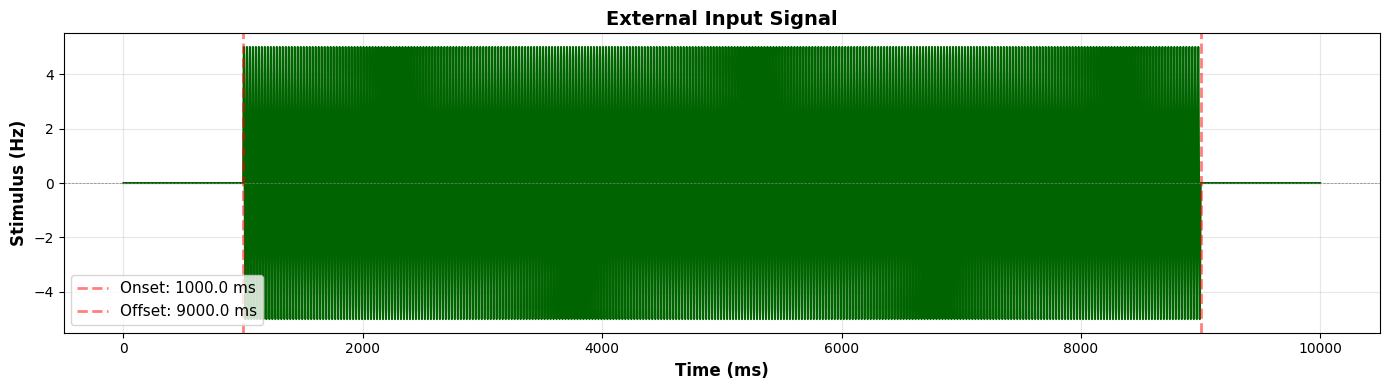

In [ ]:
# Plot stimulus if non-zero
if np.any(stim_array != 0):
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(ts, stim_array, linewidth=1.5, color='darkgreen')
    ax.set_xlabel('Time (ms)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Stimulus (Hz)', fontsize=12, fontweight='bold')
    ax.set_title('External Input Signal', fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    
    # Mark onset and offset
    if stim_config['onset_ms'] > 0:
        ax.axvline(stim_config['onset_ms'], color='red', linestyle='--', 
                   linewidth=2, alpha=0.5, label=f"Onset: {stim_config['onset_ms']} ms")
    if stim_config['offset_ms'] < duration_ms:
        ax.axvline(stim_config['offset_ms'], color='red', linestyle='--', 
                   linewidth=2, alpha=0.5, label=f"Offset: {stim_config['offset_ms']} ms")
    
    ax.legend(fontsize=11)
    plt.tight_layout()
    plt.show()
else:
    print("No external stimulus applied (baseline mode only)")

---

# Section 7: Summary & Interpretation

## Simulation Summary

In [ ]:
# === Run and compare all 6 types ===
# Note: this re-runs the model for each type and plots in a 2x3 grid.
from core_wendling.wendling_param_sets import WENDLING_TYPE_PARAMS, list_type_params
from core_wendling.stim import create_stimulus

types = list_type_params()
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=True, sharey=False)

# --- Auto y-axis scaling (centered, per-axis) ---
auto_ylim = True
scale_start_ms = 2000.0  # compute scale using data after this time
center_mode = 'median'   # 'median' or 'mean'
ylim_pct = 98            # percentile of |signal-center|
target_fill = 0.7        # 0.8-0.9 recommended
pad_frac = (1.0 / target_fill) - 1.0

def set_centered_ylim(ax, x, y, start_ms=0.0, center='median', pct=98, pad=0.1):
    import numpy as np
    yy = np.asarray(y)
    if start_ms and x is not None:
        mask = np.asarray(x) >= start_ms
        yy = yy[mask]
    yy = yy[np.isfinite(yy)]
    if yy.size == 0:
        return
    if center == 'mean':
        c = float(np.mean(yy))
    else:
        c = float(np.median(yy))
    amp = np.percentile(np.abs(yy - c), pct)
    if amp == 0:
        amp = 1
    amp = amp * (1 + pad)
    ax.set_ylim(c - amp, c + amp)


axes = axes.ravel()

for i, tname in enumerate(types):
    # Build config per type
    type_params = WENDLING_TYPE_PARAMS[tname]['params']
    config_local = dict(config)
    config_local.update(type_params)

    # Build model and runner
    model_local = WendlingSingleNode(config_local)
    model_local.reset_state()
    runner_local = bp.DSRunner(
        model_local,
        monitors={
            'lfp': model_local._lfp,
            'y1': model_local.y1,
            'y2': model_local.y2,
            'y3': model_local.y3,
        },
        dt=config_local['dt_ms']
    )

    # Generate stimulus (same as current stim_config)
    stim_obj = create_stimulus(stim_config, dt_ms=config_local['dt_ms'])
    stim_array = stim_obj.get_array(duration_ms)

    # Run
    runner_local.run(inputs=stim_array)

    # Plot LFP
    ts_local = runner_local.mon['ts']
    lfp_local = runner_local.mon['lfp']
    axes[i].plot(ts_local, lfp_local, linewidth=0.6, color='black')
    if auto_ylim:
        set_centered_ylim(axes[i], ts_local, lfp_local, start_ms=scale_start_ms, center=center_mode, pct=ylim_pct, pad=pad_frac)
    axes[i].set_title(tname)
    axes[i].grid(alpha=0.3)

axes[0].set_ylabel('LFP (mV)')
axes[3].set_ylabel('LFP (mV)')
axes[4].set_xlabel('Time (ms)')
axes[5].set_xlabel('Time (ms)')

t_start_ms = 2000
t_end_ms = 5000

for ax in axes:
    ax.set_xlim(t_start_ms, t_end_ms)

plt.tight_layout()
plt.show()


Running for 100,000 iterations:  60%|██████    | 60000/100000 [00:00<00:00, 78968.15it/s]

In [ ]:
print("="*70)
print("SIMULATION SUMMARY")
print("="*70)
print("\n### Model Configuration")
print(f"  Duration: {duration_ms} ms ({duration_ms/1000.0} s)")
print(f"  Time step: {config['dt_ms']} ms")
print(f"  Number of steps: {len(ts)}")
print(f"  Sampling rate: {1000.0 / config['dt_ms']:.1f} Hz")

print("\n### Parameter Values")
print(f"  Gains: A={config['A']} mV, B={config['B']} mV, G={config['G']} mV")
print(f"  Time constants: a={config['a']} 1/s, b={config['b']} 1/s, g={config['g']} 1/s")
print(f"  Baseline input: {config['p_mean']} ± {config['p_sigma']} Hz")

print("\n### Stimulus Configuration")
print(f"  Type: {stim_config['kind']}")
print(f"  Amplitude: {stim_config['amp']} Hz")
if stim_config['kind'] == 'sine':
    print(f"  Frequency: {stim_config.get('f_hz', 'N/A')} Hz")
print(f"  Active window: [{stim_config['onset_ms']}, {stim_config['offset_ms']}] ms")

print("\n### Output Statistics")
print(f"  LFP range: [{lfp.min():.2f}, {lfp.max():.2f}] mV")
print(f"  LFP mean: {lfp.mean():.2f} mV")
print(f"  LFP std: {lfp.std():.2f} mV")
print(f"  Dominant frequency: {peak_freq:.2f} Hz ({band})")

print("\n" + "="*70)

SIMULATION SUMMARY

### Model Configuration
  Duration: 10000.0 ms (10.0 s)
  Time step: 0.1 ms
  Number of steps: 100000
  Sampling rate: 10000.0 Hz

### Parameter Values
  Gains: A=5.0 mV, B=50.0 mV, G=15.0 mV
  Time constants: a=100.0 1/s, b=50.0 1/s, g=500.0 1/s
  Baseline input: 90.0 ± 30.0 Hz

### Stimulus Configuration
  Type: sine
  Amplitude: 5.0 Hz
  Frequency: 40.0 Hz
  Active window: [1000.0, 9000.0] ms

### Output Statistics
  LFP range: [-0.80, 1.55] mV
  LFP mean: -0.56 mV
  LFP std: 0.17 mV
  Dominant frequency: 4.88 Hz (Theta (4-8 Hz))



## Interpretation Guide

### Understanding the Output

**Local Field Potential (LFP)**:
- The LFP is computed as `y1 - y2 - y3` (excitation minus inhibitions)
- Represents the net membrane potential at pyramidal cell dendrites
- Analogous to scalp EEG or intracranial LFP recordings

**Frequency Bands**:
- **Delta (1-4 Hz)**: Deep sleep, unconsciousness
- **Theta (4-8 Hz)**: Drowsiness, meditation, memory
- **Alpha (8-13 Hz)**: Relaxed wakefulness, closed eyes
- **Beta (13-30 Hz)**: Active thinking, focus, anxiety
- **Gamma (30-100 Hz)**: Cognitive processing, attention

**Phase Portraits**:
- Show the trajectory of the system in state space
- Closed loops indicate oscillatory behavior
- Fixed points indicate equilibrium states
- Complex patterns suggest chaotic or multi-stable dynamics

### Parameter Exploration Tips

**To increase oscillation amplitude**:
- Increase `A` (excitatory gain)
- Decrease `B` or `G` (inhibitory gains)

**To change oscillation frequency**:
- Increase time constants (`a`, `b`, `g`) for slower oscillations
- Decrease time constants for faster oscillations
- Note: `g` (fast inhibition) has the strongest effect on gamma

**To simulate pathological activity**:
- Reduce inhibition: `B=10, G=8` can produce epileptiform discharges
- Increase excitation: `A=10` with normal inhibition

**To test stimulus response (ASSR)**:
- Use sinusoidal stimulus at 40 Hz
- Look for peak at 40 Hz in PSD
- Compare stimulus-on vs stimulus-off periods

### Next Steps

1. **Experiment with parameters**: Go back to Section 2 and try different presets
2. **Test different stimuli**: Try constant vs sinusoidal inputs
3. **Analyze transients**: Look at the initial dynamics vs steady-state
4. **Compare frequency bands**: Run multiple simulations with different parameters
5. **Extend to networks**: Couple multiple Wendling nodes together

### References

- **Original paper**: Wendling, F., Bartolomei, F., Bellanger, J. J., & Chauvel, P. (2002). Epileptic fast activity can be explained by a model of impaired GABAergic dendritic inhibition. *European Journal of Neuroscience*, 15(9), 1499-1508.

- **Parameter exploration**: Köksal Ersöz, E., Modolo, J., Bartolomei, F., & Wendling, F. (2020). Neural mass modeling of slow-fast dynamics of seizure initiation and abortion. *PLoS Computational Biology*, 16(11), e1008430.

- **BrainPy documentation**: https://brainpy.readthedocs.io/

---

## Congratulations!

You've successfully simulated a cortical column using the Wendling neural mass model. Feel free to:

- Modify parameters in Section 2 and re-run from Section 3 onwards
- Save this notebook with different parameter sets
- Extend the code to run parameter sweeps
- Compare results across different stimulus conditions

**Happy modeling!**